This notebook is just a showcase of how we did the sampling. The CLI command `python -m mastodon_search choose-instances` does the same, but additionally probes the timelines API of all sampled instances, removes the ones that require a token or don't answer after a timeout. Because this takes a good amount of time, it is not part of this notebook.

In [16]:
from pathlib import Path
from scipy.stats import lognorm, loguniform
from numpy import exp, linspace, logspace, geomspace
from pandas import DataFrame, concat
from seaborn import FacetGrid, histplot, set_theme
from matplotlib.pyplot import plot

from mastodon_search.instance_data.analyze import Analyzer

In [2]:
INSTANCE_DATA_PATH = Path('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-ernst/fedi_data/fedi_data_1.jsonl')
COLUMNS = {
    'total_users': "total users", 
    'monthly_users': "monthly users", 
    'total_statuses': "total posts",
    'mean_weekly_statuses': "avg. weekly statuses",
    'mean_weekly_logins': "avg. weekly logins",
    'mean_weekly_registrations': "avg. weekly registrations"
}

In [3]:
with open(INSTANCE_DATA_PATH, 'r') as file:
    an = Analyzer(file)

Number of fediverse instances in input file: 22178
Removed for (partially) no data: 12578
↳ Almost all of these instances run fediverse software other than Mastodon, some run Mastodon with a non-public API.
Removed duplicates: 2
Remaining: 9598


In [20]:
cols_prob_measures = {
    col: lognorm
    # col: loguniform
    for col in COLUMNS.keys()
}

In [24]:
df = an.df
df = df[df["total_statuses"] > 0]
df

,total_users,monthly_users,total_statuses,mean_weekly_statuses,mean_weekly_logins,mean_weekly_registrations
instance,,,,,,
0371.uk,1,1,125,3.50,1.00,0.0
0ab.uk,2,2,14,0.00,0.50,0.0
0rb.it,7,2,626,0.00,1.50,0.0
0x3c.pl,91,9,2305,1.00,5.00,0.0
0x50.ch,1,0,2,0.00,0.00,0.0
...,...,...,...,...,...,...
zusammenhalt.de,1,1,32,5.75,1.00,0.0
zusammenkunft.net,2,2,5164,69.00,2.00,0.0
zweibruecken.social,3,2,497,0.75,1.25,0.0


In [40]:
# Estimate probability distributions over activity columns
distributions = {
    col: dist(dist.fit(df[col]))
    for col, dist in cols_prob_measures.items()
}
distributions

{'total_users': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f77936d2a50>,
 'monthly_users': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f779366f7d0>,
 'total_statuses': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f77938d7cd0>,
 'mean_weekly_statuses': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f77936e2fd0>,
 'mean_weekly_logins': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f779421e1d0>,
 'mean_weekly_registrations': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f77936e6750>}

In [26]:
df_plot = concat([
    df.reset_index()[["instance", col]].rename(columns={col: "value"}).assign(statistic=name, col=col)
    for col, name in COLUMNS.items()
])
df_plot

,instance,value,statistic,col
0,0371.uk,1.0,total users,total_users
1,0ab.uk,2.0,total users,total_users
2,0rb.it,7.0,total users,total_users
3,0x3c.pl,91.0,total users,total_users
4,0x50.ch,1.0,total users,total_users
...,...,...,...,...
9162,zusammenhalt.de,0.0,avg. weekly registrations,mean_weekly_registrations
9163,zusammenkunft.net,0.0,avg. weekly registrations,mean_weekly_registrations
9164,zweibruecken.social,0.0,avg. weekly registrations,mean_weekly_registrations
9165,zx81.social,0.0,avg. weekly registrations,mean_weekly_registrations


/home/heinrich/Repositories/mastodon-search/venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6349: RuntimeWarning: divide by zero encountered in divide
  lambda x, s: (-np.log(x)**2 / (2 * s**2)


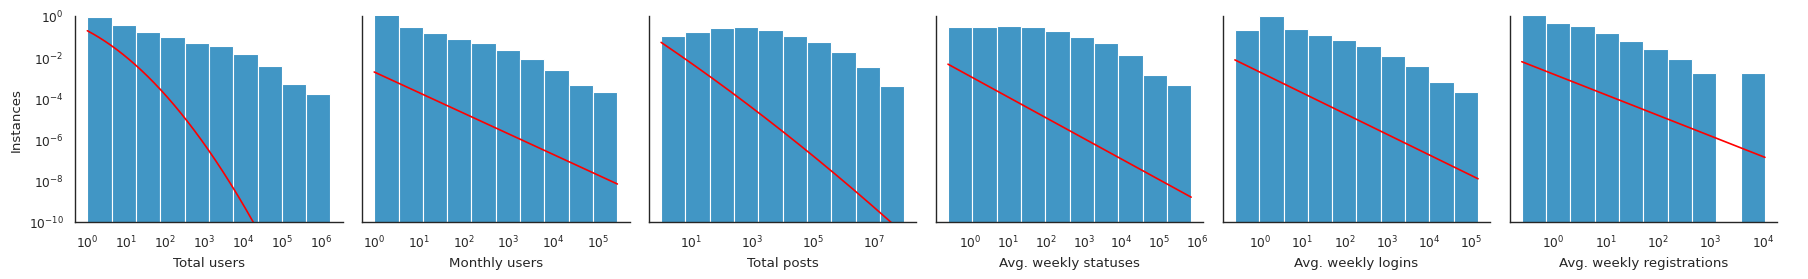

In [58]:
set_theme(style="white", context="paper", palette="colorblind")
g = FacetGrid(
    data=df_plot, 
    col="statistic", 
    sharex=False, 
    # sharey=True,
    ylim=(1e-10, 1),
)
g.map(
    histplot,
    "value",
    bins=10, 
    log_scale=(True, True),
    fill=True,
    stat="density",
)
g.set(yscale="log")
g.set_titles(template="")
for name, ax in g.axes_dict.items():
    name: str
    col = next(c for c, n in COLUMNS.items() if n == name)
    dist = distributions[col]
    min_x = df[df[col] > 0][col].min()
    max_x = df[col].max()
    xs = geomspace(
        start=min_x,
        stop=max_x, 
        num=1000,
    )
    ys = [dist.pdf(i)[0] for i in xs]
    ylim = ax.get_ylim()
    ax.plot(xs, ys, color="red")
    # ax.set_ylim(ylim)
    ax.set_xlabel(name[:1].capitalize() + name[1:])
g.set(ylabel="Instances")
g.add_legend()
g.savefig("../data/histograms-instance-statistics.pdf")
g

In [50]:
SAMPLE_INSTANCE_PATH = Path('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-ernst/sample/06/instances.txt')
with SAMPLE_INSTANCE_PATH.open("rt") as file:
    instances_sample = [line.strip() for line in file]
instances_sample[:10] 

['23.illuminati.org',
 '3615.computer',
 '3dp.chat',
 '3zi.ru',
 '4bear.com',
 '60jj.masto.host',
 '9kb.me',
 'a11y.social',
 'a2mi.social',
 'abdl.link']

In [51]:
df_sample = df_plot[df_plot["instance"].isin(instances_sample)]
df_sample

,instance,value,statistic,col
19,23.illuminati.org,152.00,total users,total_users
31,3dp.chat,112.00,total users,total_users
34,3zi.ru,14.00,total users,total_users
39,4bear.com,1174.00,total users,total_users
46,60jj.masto.host,7.00,total users,total_users
...,...,...,...,...
9142,zh.pp.social,1.00,avg. weekly registrations,mean_weekly_registrations
9144,zhub.link,0.25,avg. weekly registrations,mean_weekly_registrations
9145,zirk.us,9.25,avg. weekly registrations,mean_weekly_registrations
9156,zpravobot.news,4.25,avg. weekly registrations,mean_weekly_registrations


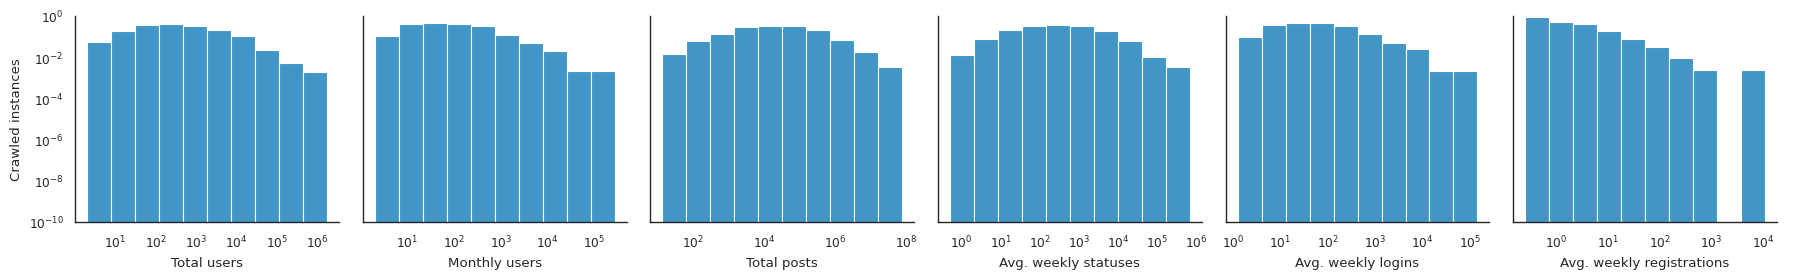

In [59]:
set_theme(style="white", context="paper", palette="colorblind")
g = FacetGrid(
    data=df_sample, 
    col="statistic", 
    sharex=False, 
    # sharey=True,
    ylim=(1e-10, 1),
)
g.map(
    histplot,
    "value",
    bins=10, 
    log_scale=(True, True),
    fill=True,
    stat="density",
)
g.set(yscale="log")
g.set_titles(template="")
for name, ax in g.axes_dict.items():
    name: str
    ax.set_xlabel(name[:1].capitalize() + name[1:])
g.set(ylabel="Crawled instances")
g.add_legend()
g.savefig("../data/histograms-instance-statistics-sample.pdf")
g